## Stock Analysis with Technical Indicators

This notebook analyzes historical stock data using:
- SMA/EMA crossover signals
- RSI momentum indicator
- A simple backtested trading strategy

We simulate trades and calculate the performance of this strategy based on user-input stock symbols over a 6-month period.


In [1]:
# Retrieving data from the past 6 months:

import yfinance as yf

# Prompt user to input a stock ticker (e.g., AAPL, TSLA):
symbol = input("Enter stock ticker (e.g. AAPL): ").upper()

# Retrieving 6 months of daily historical data for the entered ticker symbol:
company_data = yf.Ticker(symbol).history(period="6mo")
company_data.dropna(inplace=True)  # Clean any missing values

company_data

Enter stock ticker (e.g. AAPL):  MSFT


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-29 00:00:00-05:00,444.979212,445.168487,438.713294,440.635895,23581400,0.0,0.0
2025-01-30 00:00:00-05:00,417.166126,421.240458,411.577626,413.400604,54586300,0.0,0.0
2025-01-31 00:00:00-05:00,417.375368,419.078810,413.320948,413.470367,34161900,0.0,0.0
2025-02-03 00:00:00-05:00,410.023610,413.819016,407.094868,409.346222,25679100,0.0,0.0
2025-02-04 00:00:00-05:00,411.109431,412.334731,408.170717,410.790649,20532100,0.0,0.0
...,...,...,...,...,...,...,...
2025-07-22 00:00:00-04:00,510.970001,511.200012,505.269989,505.269989,13868600,0.0,0.0
2025-07-23 00:00:00-04:00,506.750000,506.790009,500.700012,505.869995,16396600,0.0,0.0
2025-07-24 00:00:00-04:00,508.769989,513.669983,507.299988,510.880005,16107000,0.0,0.0


### Technical Indicators Explained

- **Simple Moving Average (SMA)**: Averages the last *N* closing prices. Helps identify long-term trends.
- **Exponential Moving Average (EMA)**: Similar to SMA, but gives more weight to recent prices. Reacts faster to price changes, so it is useful for short-term trends.
  - The EMA crossing above the SMA is a potential buy signal.
  - The EMA crossing below the SMA is a potential sell signal.
- **Relative Strength Index (RSI)**: Measures the strength of recent price changes. Returns a value between 0 and 100 to indicate momentum.
  - If the RSI is below 30, the asset may be oversold. This is a potential buy signal.
  - If the RSI is above 70, the asset may be overbought. This is a potential sell signal.


In [2]:
# Calculating SMA, EMA and RSI:

import pandas as pd
import numpy as np

# Calculating 20-day SMA of closing prices:
company_data['SMA_20'] = company_data['Close'].rolling(window=20).mean()

# Calculating 20-day EMA, weighted toward recent prices:
company_data['EMA_20'] = company_data['Close'].ewm(span=20, adjust=False).mean()

# # Calculating 14-day RSI:
delta = company_data['Close'].diff() # Daily closing price change
gain = delta.clip(lower=0).rolling(window=14).mean() # 14-day average of gains
loss = -delta.clip(upper=0).rolling(window=14).mean() # 14-day average of losses
rs = gain / loss # Relative strength.
company_data['RSI'] = 100 - (100 / (1 + rs)) # RSI formula


### Signal Detection Logic

We generate trading signals based on the **SMA/EMA crossover** strategy:

- We represent a buy signal as 1 (bullish crossover).
- We represent a sell signal as -1 (bearish crossover).
- We represent no signal as 0 (no action).

These signals will be used to simulate trading behavior later.

In [3]:
# Detecting crossover signals:

company_data['Signal'] = 0  

# Buy Signal: when EMA crosses **above** SMA (bullish crossover).
company_data.loc[
    (company_data['EMA_20'] > company_data['SMA_20']) &
    (company_data['EMA_20'].shift(1) <= company_data['SMA_20'].shift(1)),
    'Signal'
] = 1

# Sell Signal: when EMA crosses **below** SMA (bearish crossover).
company_data.loc[
    (company_data['EMA_20'] < company_data['SMA_20']) &
    (company_data['EMA_20'].shift(1) >= company_data['SMA_20'].shift(1)),
    'Signal'
] = -1

# Buy/sell signal according to the latest data:
# Get latest signal (from most recent date) to print actionable output.
latest_signal = company_data['Signal'].iloc[-1]
if latest_signal == 1:
    print("SMA/EMA CROSSOVER SIGNAL: BUY")
elif latest_signal == -1:
    print("SMA/EMA CROSSOVER SIGNAL: SELL")
else:
    print("SMA/EMA CROSSOVER SIGNAL: HOLD")


SMA/EMA CROSSOVER SIGNAL: HOLD


### Visualising SMA, EMA and Crossover Signals

We now plot our averages along with any detected signals.

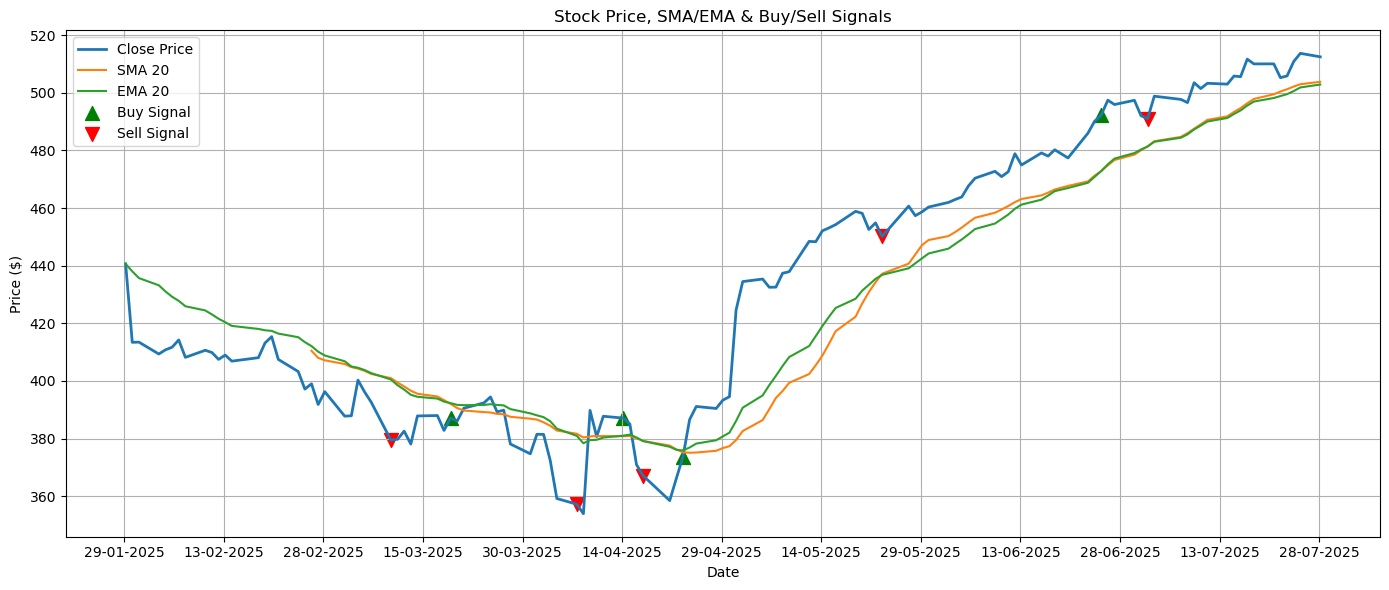

In [4]:
# Plotting price, SMA, EMA and signals:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Identify all buy and sell points based on crossover signals:
buy_signals = company_data[company_data['Signal'] == 1]
sell_signals = company_data[company_data['Signal'] == -1]

# Plotting closing price, SMA, EMA, and buy/sell signals on the same chart:
plt.figure(figsize=(14,6))
plt.plot(company_data['Close'], label='Close Price', linewidth=2)
plt.plot(company_data['SMA_20'], label='SMA 20')
plt.plot(company_data['EMA_20'], label='EMA 20')

plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=100)

plt.title('Stock Price, SMA/EMA & Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  
plt.tight_layout()
plt.show()


### Backtesting the Strategy

We simulate a simple trading strategy using the SMA/EMA crossover signals:

- Start with **$10,000** in cash
- Buy as many shares as possible when `Signal == 1`
- Sell all shares when `Signal == -1`
- Track the daily **portfolio value**: `cash + (shares * current price)`

In [5]:
# Initialize backtest: start with $10,000 in cash and 0 shares.
cash = 10000
shares = 0
portfolio_value = []

# Loop through each row to simulate trading:
for i in range(len(company_data)):
    price = company_data['Close'].iloc[i]
    signal = company_data['Signal'].iloc[i] 

    # Buy Signal: use all cash to buy as many full shares as possible.
    if signal == 1 and cash > 0:
        shares = cash // price
        cash -= shares * price

    # Sell Signal: sell all held shares at current price.
    elif signal == -1 and shares > 0:
        cash += shares * price
        shares = 0

    # Track total portfolio value: cash + value of current holdings.
    portfolio_value.append(cash + shares * price)

# Store daily portfolio value in a new column:
company_data['Portfolio Value'] = portfolio_value

### Visualising the Portfolio Value

Number of Buy signals: 4
Number of Sell signals: 5
Final Portfolio Value: $10,526.70
Return: 5.27%


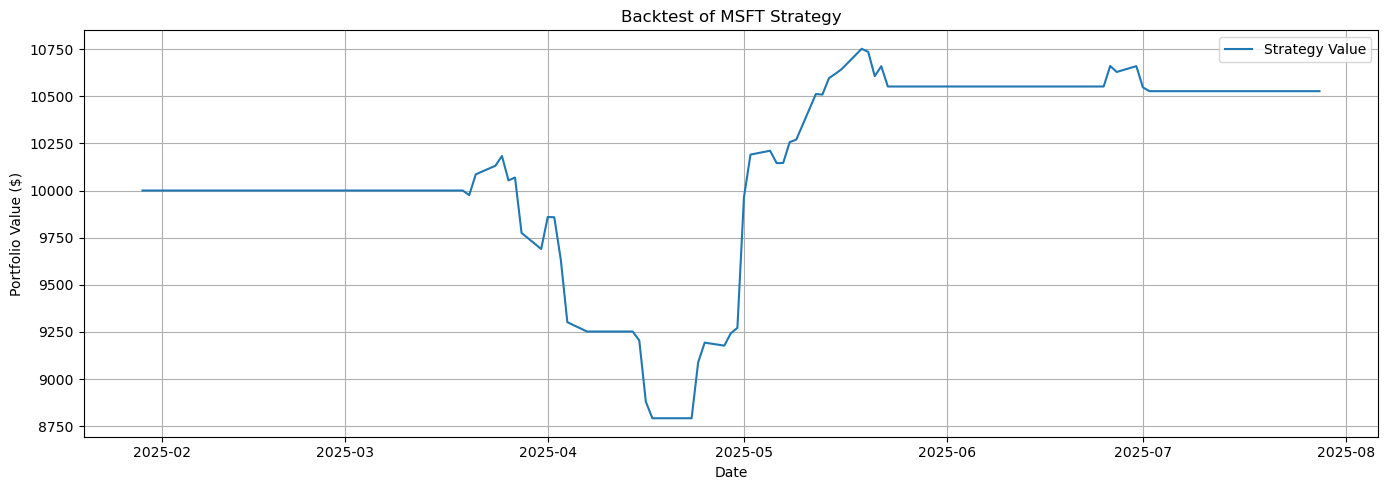

In [6]:
# Results:

# Print backtest summary: number of signals, final portfolio value, and return %.
print("Number of Buy signals:", (company_data['Signal'] == 1).sum())
print("Number of Sell signals:", (company_data['Signal'] == -1).sum())
final_value = company_data['Portfolio Value'].iloc[-1]
returns = (final_value - 10000) / 10000 * 100
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Return: {returns:.2f}%")

# Plotting portfolio value:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(company_data.index, company_data['Portfolio Value'], label='Strategy Value')
plt.title(f"Backtest of {symbol} Strategy")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### RSI-Based Buy/Sell Signals

We now apply the RSI indicator for signal generation:

- RSI < 30: potential buy signal
- RSI > 70: potential sell signal

We'll use this to complement the crossover strategy.

In [7]:
# Detecting signals using RSI:

# Retrieving most recent RSI data:
latest_rsi = company_data['RSI'].dropna().iloc[-1]

# Analysis using RSI:
if latest_rsi < 30:
    print(f"BUY SIGNAL: RSI is {latest_rsi:.2f} (< 30)")
elif latest_rsi > 70:
    print(f"SELL SIGNAL: RSI is {latest_rsi:.2f} (> 70)")
else:
    print(f"HOLD: RSI is {latest_rsi:.2f}")


SELL SIGNAL: RSI is 71.91 (> 70)


### Visualising the RSI and its Signals

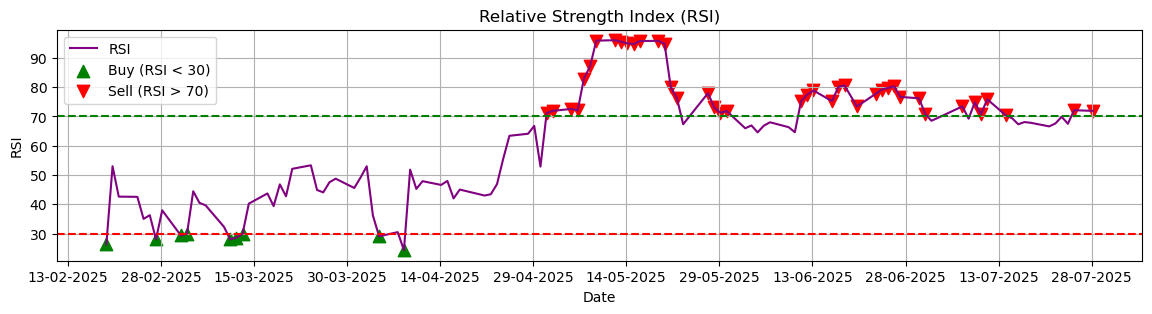

In [8]:
# Plot RSI with buy/sell markers at thresholds (<30 and >70)

# Plotting RSI with signal markers:
plt.figure(figsize=(14, 3))
plt.plot(company_data['RSI'], label='RSI', color='purple')

# Add RSI threshold lines:
plt.axhline(30, color='red', linestyle='--')
plt.axhline(70, color='green', linestyle='--')

# Mark Buy/Sell signals on RSI:
buy_rsi = company_data[company_data['RSI'] < 30]
sell_rsi = company_data[company_data['RSI'] > 70]

plt.scatter(buy_rsi.index, buy_rsi['RSI'], label='Buy (RSI < 30)', color='green', marker='^', s=80)
plt.scatter(sell_rsi.index, sell_rsi['RSI'], label='Sell (RSI > 70)', color='red', marker='v', s=80)

plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

plt.show()


### Combining Strategies: RSI + SMA/EMA Crossover

While RSI signals alone are often too noisy or infrequent to form a complete trading strategy, they become much more powerful when combined with trend-based indicators.

In this step, we create a **combined signal** by requiring:
- A buy signal only when:
  - The EMA crosses above the SMA (bullish crossover) **and**
  - The RSI is below 30 (indicating the stock is oversold)

  
- A sell signal only when:
  - The EMA crosses below the SMA (bearish crossover) **and**
  - The RSI is above 70 (indicating the stock is overbought)

This approach ensures that trades are made only when momentum and trend indicators agree, reducing false signals.

In [9]:
# Combined Signal: only buy if crossover happens AND RSI confirms it.

company_data['Combined_Signal'] = 0

company_data.loc[
    (company_data['Signal'] == 1) & (company_data['RSI'] < 30),
    'Combined_Signal'
] = 1

company_data.loc[
    (company_data['Signal'] == -1) & (company_data['RSI'] > 70),
    'Combined_Signal'
] = -1

# Results:
print("Buy signals:", (company_data['Combined_Signal'] == 1).sum())
print("Sell signals:", (company_data['Combined_Signal'] == -1).sum())


Buy signals: 0
Sell signals: 0


## Summary

Using Microsoft (`MSFT`) stock data over the past 6 months, we applied a basic technical strategy involving:

- SMA/EMA Crossover Signals
- RSI-Based Confirmation
- Simulated backtesting with $10,000 starting capital

### Crossover Strategy Results:
- Buy Signals: 4  
- Sell Signals: 5  
- Final Return: +5.27%

This indicates the crossover approach captured some meaningful trend shifts during the 6-month window and generated a moderate gain.

---

### Combined Strategy (Crossover + RSI Confirmation):
- Buy Signals: 0  
- Sell Signals: 0  
- No trades triggered

The lack of signals in the combined strategy highlights how strict confirmation logic can be overly conservative. It potentially avoids false signals, but also misses real opportunities.

---

### Strategy Limitations

While the SMA/EMA crossover strategy (with or without RSI) shows promise, it comes with several important limitations:

- **No risk management**  
  There are no mechanisms to cut losses, limit exposure, or lock in gains. A single bad signal could wipe out prior gains.

- **Over-sensitivity to flat markets**  
  In sideways markets, crossover signals can lead to whipsaws (frequent, unprofitable trades due to noise rather than trend).

- **Delayed entries and exits**  
  Moving averages are lagging indicators. This means signals often come after the optimal entry or exit point.

- **No transaction costs modeled**  
  Real-world factors like commissions, slippage, bid-ask spreads, and taxes aren't included. These factors can significantly impact results.

- **Strict filter may be too conservative**  
  The combined strategy (SMA/EMA + RSI) gave zero signals. While that avoids false positives, it also means missed opportunities. This is especially true if RSI thresholds are too strict.

- **All-in, all-out trades**  
  The strategy always uses the entire portfolio to buy or sell, without allowing for partial positions or diversification. This exposes the strategy to high volatility and risk concentration.

---

### Key Takeaways:
- Crossover strategies are simple but can be effective in trending markets.
- Adding momentum filters like RSI can reduce noise, but overfitting rules may eliminate all trades.
- A single stock and short time frame isn't enough to evaluate a strategy’s robustness. Broader testing is needed.

Next steps: Try testing this strategy on different tickers, longer timeframes, or modify the indicator thresholds (e.g., RSI < 35 instead of 30) to find better balance between caution and opportunity.